# Real-World Skin Cancer Model Training

This notebook trains a deep learning model for skin cancer classification, optimized for real-world performance. It incorporates several key techniques:
- **Aggressive Data Augmentation**: Simulates variations in lighting, angle, and quality found in real photos.
- **Class Imbalance Handling**: Uses `WeightedRandomSampler` to ensure the model doesn't get biased towards common classes.
- **Advanced Loss Function**: Employs `FocalLoss` to help the model focus on harder-to-classify examples.
- **Modern Architecture**: Uses the `EfficientNet-B3` model, which offers a great balance of performance and efficiency.
- **Mixed-Precision Training**: Speeds up training and reduces memory usage on modern GPUs.

In [3]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
import timm
import numpy as np
from collections import Counter

In [4]:
print(torch.__version__)

2.5.1+cu121


### Correcting Your PyTorch Installation

The output `2.7.1+cpu` confirms you have a **CPU-only** version of PyTorch installed. To use your GPU for training as intended in this notebook, you must reinstall PyTorch with CUDA support.

**Please follow these steps in your terminal (e.g., PowerShell or Command Prompt):**

1.  **Uninstall the existing CPU version:**
    ```bash
    pip uninstall torch torchvision torchaudio
    ```
    *(Answer `y` when prompted to confirm.)*

2.  **Install the correct CUDA-enabled version:**
    The best way to get the correct command is from the [official PyTorch website](https://pytorch.org/get-started/locally/). Select the "Stable" build, your OS ("Windows"), package manager ("Pip"), and the appropriate CUDA version.

    A common command for a recent CUDA version (e.g., 12.1) is:
    ```bash
    pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
    ```

**After running these commands, please restart VS Code completely.** Then, come back to this notebook and re-run the cell that prints the PyTorch version. The output should no longer contain `+cpu` (for example, it might be `2.7.1+cu121`). Once that's confirmed, you can proceed with running the rest of the notebook.


## 1. Configuration

Set up the main parameters for the training process. This includes selecting the device (GPU is required), defining data paths, choosing the model, and setting hyperparameters.

In [ ]:
# --- Configuration ---
# Device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == 'cpu':
    print("Error: This script is designed to run on a GPU. Please ensure CUDA is available and the correct PyTorch version is installed.")
    # In a notebook, we raise an error instead of exiting.
    raise RuntimeError("CUDA is not available. Please check your installation.")

# Dataset path
data_dir = "ham10000_processed"

# Model choice - More robust models are better for real-world generalization
# Options: "efficientnet_b3", "convnext_tiny", "efficientnet_b0", "mobilenet_v3"
MODEL_CHOICE = "efficientnet_b3"

# Training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 15 # Increased epochs for more robust training
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
# --- End Configuration ---

Using device: cuda


## 2. Data Augmentation

Define the data augmentation pipelines. The training transform is aggressive to simulate real-world image variations like different angles, lighting, and blur. The validation transform is minimal, only resizing and normalizing.

In [6]:
# These transforms are more aggressive to simulate real-world image variations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Start with a slightly larger size before cropping
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(60), # Increased rotation
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3), # Added perspective transform
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Stronger color jitter
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)), # Added blur
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## 3. Focal Loss for Class Imbalance

Define the Focal Loss function. This loss function helps the model focus on hard-to-classify examples by down-weighting the loss assigned to well-classified examples. It's particularly useful for datasets with significant class imbalance.

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

## 4. Dataset Loading and Preprocessing

Load the dataset from the specified directory. We then split the dataset into training and validation sets and apply the respective transformations.

In [8]:
# --- Dataset Loading and Splitting ---
full_dataset = datasets.ImageFolder(root=data_dir)
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {full_dataset.classes}")

# Train/val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(full_dataset)), [train_size, val_size])

# Create separate datasets with the correct transforms
train_dataset = torch.utils.data.Subset(datasets.ImageFolder(root=data_dir, transform=train_transform), train_indices.indices)
val_dataset = torch.utils.data.Subset(datasets.ImageFolder(root=data_dir, transform=val_transform), val_indices.indices)

Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


## 5. Class Imbalance Handling with WeightedRandomSampler

To counteract the class imbalance in the HAM10000 dataset, we calculate weights for each class based on their frequency. The `WeightedRandomSampler` then uses these weights to ensure that each batch contains a more balanced representation of all classes.

In [9]:
# --- WeightedRandomSampler for Class Imbalance ---
print("\nHandling class imbalance with WeightedRandomSampler...")
# Get labels for the training split
train_labels = [full_dataset.targets[i] for i in train_indices.indices]

# Count class occurrences
class_counts = Counter(train_labels)
print(f"Training class distribution: {class_counts}")

# Calculate weights for each class (inverse of frequency)
class_weights = {class_id: 1.0 / count for class_id, count in class_counts.items()}

# Create a weight for each sample in the training set
sample_weights = [class_weights[label] for label in train_labels]

# Create the sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
print("[SUCCESS] WeightedRandomSampler created.")


Handling class imbalance with WeightedRandomSampler...
Training class distribution: Counter({5: 5375, 4: 886, 2: 862, 1: 415, 0: 271, 6: 116, 3: 87})
[SUCCESS] WeightedRandomSampler created.


## 6. Create DataLoaders

Create the `DataLoaders` for the training and validation sets. The training loader uses the `sampler`, so `shuffle` is set to `False`.

In [10]:
# --- DataLoaders ---
# Note: shuffle=False because the sampler handles random sampling.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

## 7. Model Setup

Load the pre-trained model using `timm`. We add a dropout layer to the classifier for extra regularization, which helps prevent overfitting. Finally, we move the model to the selected GPU device and print the number of parameters.

In [11]:
# --- Model Selection ---
print(f"\nLoading model: {MODEL_CHOICE}...")
model = timm.create_model(MODEL_CHOICE, pretrained=True, num_classes=num_classes)
model_name = MODEL_CHOICE

# Add dropout to the classifier for regularization
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):
    dropout_rate = 0.4 # Slightly increased dropout
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate, inplace=True),
        model.classifier
    )
    print(f"Added Dropout ({dropout_rate}) to the classifier.")

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Loading model: efficientnet_b3...
Added Dropout (0.4) to the classifier.
Total parameters: 10,706,991
Trainable parameters: 10,706,991


## 8. Training Setup

Configure the components needed for training: the loss function (`FocalLoss`), the optimizer (`AdamW`), a learning rate scheduler (`CosineAnnealingWarmRestarts`), and a `GradScaler` for mixed-precision training.

In [12]:
# --- Training Setup ---
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
scaler = GradScaler()

C:\Users\shenl\AppData\Local\Temp\ipykernel_20156\3624999201.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## 9. Training Loop

This is the main training loop. It iterates for the specified number of epochs, performing the following steps in each epoch:
1.  **Training Phase**: The model is set to `train()` mode. It processes batches from the `train_loader`, calculates the loss, and updates the weights using the optimizer and scaler.
2.  **Validation Phase**: The model is set to `eval()` mode. It evaluates performance on the `val_loader` without updating weights.
3.  **Model Checkpointing**: If the validation accuracy improves, the model's state is saved.
4.  **Logging**: Prints the loss, accuracy, and learning rate for each epoch.

In [13]:
# --- Training Loop ---
train_accs, val_accs, train_losses, val_losses = [], [], [], []
best_val_acc = 0.0

print(f"\nStarting training with {model_name} for {NUM_EPOCHS} epochs...")
print("-" * 80)

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx > 0 and batch_idx % 25 == 0:
            print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    train_acc = correct / total
    train_loss /= len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss /= len(val_loader)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    scheduler.step()
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"best_{model_name}_realworld.pth")
        print(f"[SUCCESS] New best model saved with val_acc: {val_acc:.4f}")

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Current LR: {current_lr:.6f}")
    print("-" * 80)

print("\n[SUCCESS] Training loop completed.")


Starting training with efficientnet_b3 for 30 epochs...
--------------------------------------------------------------------------------


C:\Users\shenl\AppData\Local\Temp\ipykernel_20156\1624460562.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30, Batch 25/251, Loss: 4.1167
Epoch 1/30, Batch 50/251, Loss: 2.4900
Epoch 1/30, Batch 75/251, Loss: 2.2282
Epoch 1/30, Batch 100/251, Loss: 1.5457
Epoch 1/30, Batch 125/251, Loss: 1.5157
Epoch 1/30, Batch 150/251, Loss: 1.5855
Epoch 1/30, Batch 175/251, Loss: 1.5940
Epoch 1/30, Batch 200/251, Loss: 1.1869
Epoch 1/30, Batch 225/251, Loss: 1.1171
Epoch 1/30, Batch 250/251, Loss: 0.9848


C:\Users\shenl\AppData\Local\Temp\ipykernel_20156\1624460562.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[SUCCESS] New best model saved with val_acc: 0.4753
Epoch [1/30], Train Loss: 2.0177, Train Acc: 0.3226, Val Loss: nan, Val Acc: 0.4753
Current LR: 0.000098
--------------------------------------------------------------------------------
Epoch 2/30, Batch 25/251, Loss: 0.9577
Epoch 2/30, Batch 50/251, Loss: 1.5585
Epoch 2/30, Batch 75/251, Loss: 0.9055
Epoch 2/30, Batch 100/251, Loss: 0.8928
Epoch 2/30, Batch 125/251, Loss: 0.7431
Epoch 2/30, Batch 150/251, Loss: 0.7333
Epoch 2/30, Batch 175/251, Loss: 1.0067
Epoch 2/30, Batch 200/251, Loss: 1.1895
Epoch 2/30, Batch 225/251, Loss: 0.8647
Epoch 2/30, Batch 250/251, Loss: 1.0462
[SUCCESS] New best model saved with val_acc: 0.6116
Epoch [2/30], Train Loss: 0.9882, Train Acc: 0.5020, Val Loss: 0.8584, Val Acc: 0.6116
Current LR: 0.000091
--------------------------------------------------------------------------------
Epoch 3/30, Batch 25/251, Loss: 0.5919
Epoch 3/30, Batch 50/251, Loss: 1.1307
Epoch 3/30, Batch 75/251, Loss: 0.6025
Epoch 3

## 10. Finalization and Plotting

After the training is complete, the final model is saved. We then generate and display plots of the training and validation accuracy and loss over all epochs to visualize the model's learning progress. The plot is also saved to a file.

[SUCCESS] Final model saved as final_efficientnet_b3_realworld.pth
[SUCCESS] Best validation accuracy achieved: 0.8293


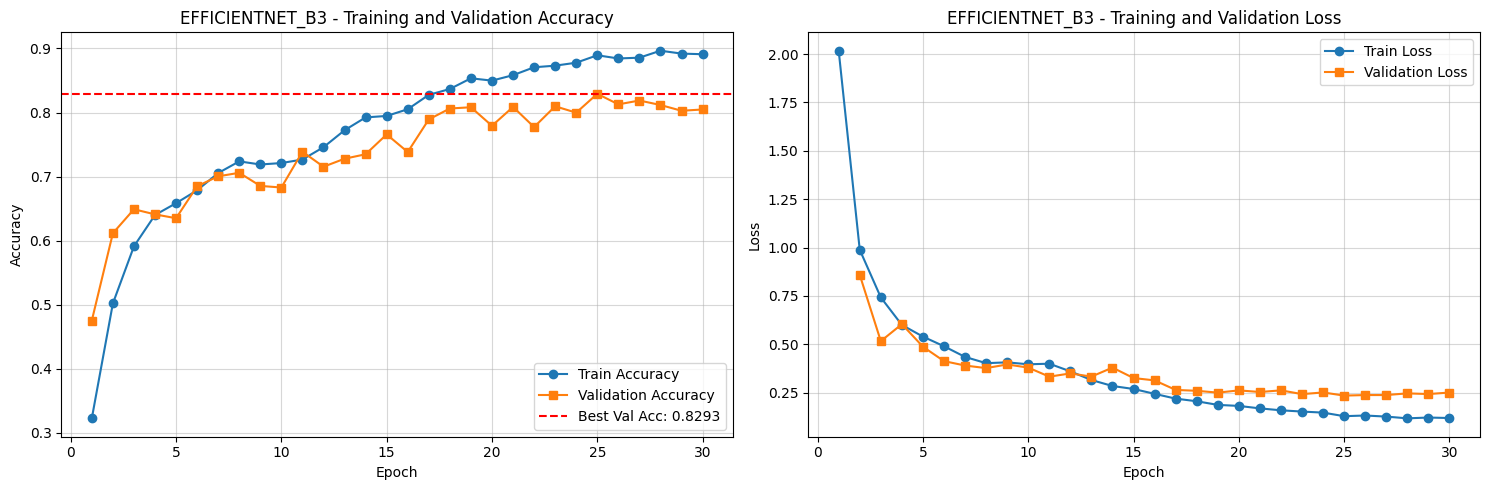


[SUCCESS] Training completed!
[RESULTS] Final Results:
   - Model: efficientnet_b3
   - Best Validation Accuracy: 0.8293
   - Total Parameters: 10,706,991
   - Training completed in 30 epochs


In [14]:
# --- Finalization and Plotting ---
torch.save(model.state_dict(), f"final_{model_name}_realworld.pth")
print(f"[SUCCESS] Final model saved as final_{model_name}_realworld.pth")
print(f"[SUCCESS] Best validation accuracy achieved: {best_val_acc:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, NUM_EPOCHS+1), train_accs, label='Train Accuracy', marker='o')
ax1.plot(range(1, NUM_EPOCHS+1), val_accs, label='Validation Accuracy', marker='s')
ax1.axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best Val Acc: {best_val_acc:.4f}')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title(f"{model_name.upper()} - Training and Validation Accuracy")
ax1.legend()
ax1.grid(True, alpha=0.5)

ax2.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss', marker='o')
ax2.plot(range(1, NUM_EPOCHS+1), val_losses, label='Validation Loss', marker='s')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title(f"{model_name.upper()} - Training and Validation Loss")
ax2.legend()
ax2.grid(True, alpha=0.5)

plt.tight_layout()
plt.savefig(f"{model_name}_realworld_training_plot.png", dpi=300)
plt.show()

print(f"\n[SUCCESS] Training completed!")
print(f"[RESULTS] Final Results:")
print(f"   - Model: {model_name}")
print(f"   - Best Validation Accuracy: {best_val_acc:.4f}")
print(f"   - Total Parameters: {total_params:,}")
print(f"   - Training completed in {NUM_EPOCHS} epochs")